<a href="https://colab.research.google.com/github/PatriciaLucas/CNN/blob/master/Notebook_EnsembleCNN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt

kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(np.array([3,5,6,7,8,15,-10]).reshape(-1,1))

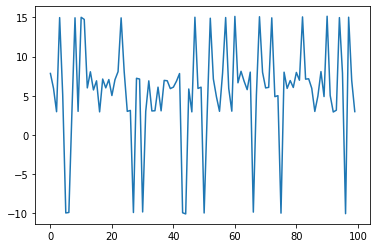

In [79]:
data = kde.sample(100)
fig = plt.figure()
plt.plot(data)

# Reference evapotranspiration forecast with CNN1 Ensemble

  


In [ ]:
!pip install keras-tcn
from tcn import TCN
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
import warnings
from google.colab import files
warnings.filterwarnings("ignore")
import keras 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
RUTA = '/content/drive/MyDrive/Universidad/Evapotranspiration-Prediction-2022/prediction/tcn/CNN - ET0/'
RUTA2 = '/content/drive/MyDrive/Universidad/Evapotranspiration-Prediction-2022/data_processing/data/'
import importlib.util

def module_from_file(module_name, file_path):
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module
# Equivalencia a from CNN import Ensemble_estruturado as es
es = module_from_file("es",RUTA+"CNN/Ensemble_estruturado.py")

# Equivalencia a from CNN import Ensemble_estruturado as es
basic = module_from_file("basic",RUTA+"CNN/basic.py")
eCNN = module_from_file("eCNN",RUTA+"CNN/Ensemble_CNN.py")

##Reference evapotranpiration database

In [ ]:
def get_search_dataset():
    # df1 = pd.read_csv('https://raw.githubusercontent.com/PatriciaLucas/Evapotranspiracao/master/ETo_setelagoas.csv', sep=',')
    df1 = pd.read_csv(RUTA2+'agrometeorologia-20220803074234.csv', sep=',')
    series = df1.iloc[:,1]
    # train = series[:6939]
    # test = series[8035:] #ano de teste: 2015
    train = series[:-365]
    test = series[-365:]
    print(series)
    return train, test

train, test = get_search_dataset()

0       3.78
1       4.07
2       4.96
3       5.22
4       4.89
        ... 
3905    1.19
3906    0.61
3907    1.07
3908    0.92
3909    1.03
Name: Eto, Length: 3910, dtype: float64


In [ ]:
df2 = pd.read_csv(RUTA2+'ETO_TEST.csv', sep=',')
series2 = df2.iloc[:,1]
test = series2[-365:]

##Using the Ensemble CNN1 model to predict reference evapotranspiration


In [ ]:
TYPE_MODEL = 'CNN3'
model = eCNN.Ensemble_CNN(type_models=TYPE_MODEL, number= 6) #Creating the ensemble with 6 CNN1 models
model.generate_models()         # Generates CNN models

In [ ]:
model.fit(data = train.values) # Treina os modelos CNN

In [ ]:
# GUARDAR MODELOS ENTRENADOS

savename = RUTA+'E'+TYPE_MODEL+'_MODELS/model_'
model.trained_models[0].save(RUTA+'E'+TYPE_MODEL+'_MODELS/model_0.h5')
model.trained_models[1].save(RUTA+'E'+TYPE_MODEL+'_MODELS/model_1.h5')
model.trained_models[2].save(RUTA+'E'+TYPE_MODEL+'_MODELS/model_2.h5')
model.trained_models[3].save(RUTA+'E'+TYPE_MODEL+'_MODELS/model_3.h5')
model.trained_models[4].save(RUTA+'E'+TYPE_MODEL+'_MODELS/model_4.h5')
model.trained_models[5].save(RUTA+'E'+TYPE_MODEL+'_MODELS/model_5.h5')

In [ ]:
model.models[5]

{'pilhas': 2,
 'filters': 1,
 'dropout': 0.3123470113230384,
 'norm': 1,
 'lags': 64,
 'num_conv': 4,
 'kernel_size': 3,
 'tipo': 2}

In [ ]:
# CARGAR MODELOS GUARDADOS
mdl = keras.models.load_model(RUTA+'E'+TYPE_MODEL+'_MODELS/model_5.h5',custom_objects={'TCN': TCN})

In [ ]:
# OBTENER LAGS
lags = mdl.input_shape[1]
lags

64

In [ ]:
model.trained_models[0].get_config()

{'name': 'model_6',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 4, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_7'},
   'name': 'input_7',
   'inbound_nodes': []},
  {'class_name': 'TCN',
   'config': {'name': 'tcn',
    'trainable': True,
    'dtype': 'float32',
    'nb_filters': 32,
    'kernel_size': 5,
    'nb_stacks': 1,
    'dilations': ListWrapper([1]),
    'padding': 'causal',
    'use_skip_connections': False,
    'dropout_rate': 0.3994542750755439,
    'return_sequences': False,
    'activation': 'relu',
    'use_batch_norm': False,
    'use_layer_norm': False,
    'use_weight_norm': False,
    'kernel_initializer': 'he_normal'},
   'name': 'tcn',
   'inbound_nodes': [[['input_7', 0, 0, {}]]]},
  {'class_name': 'Dense',
   'config': {'name': 'dense_6',
    'trainable': True,
    'dtype': 'float32',
    'units': 1,
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'cla

####Point forecast for 5 days ahead

In [ ]:
yhat, y_test,_ = model.point_forecast(data = test.values, forecast_horizon=5)
rmse, mae, mape = model.metrics(yhat = yhat, y_test=y_test, forecast_horizon=5)
print("RMSE", rmse)
print("MAE",mae)
print("MAPE",mape)

RMSE [0.5911694838224789, 0.6502123132618811, 0.7260896429493576, 0.767994344214584, 0.8282336727696177]
MAE [0.4749892214407441, 0.5081538463099492, 0.566512222818381, 0.5956233534643512, 0.6420267957282016]
MAPE [18.891329427181837, 19.355914528373543, 20.60191829877844, 21.302319126466596, 22.516817701692396]


In [ ]:
yhat

array([[4.43668021, 4.07476434, 3.85792311, 3.83687477, 3.73336147],
       [4.3870696 , 4.05221282, 3.99257557, 3.84839812, 3.65248083],
       [4.11646056, 3.97321832, 3.81575552, 3.65224423, 3.58658366],
       ...,
       [0.72611965, 0.69835721, 0.80719802, 0.7786414 , 0.78135935],
       [0.87358518, 0.95653396, 0.92525432, 0.91301251, 0.89196816],
       [0.91414842, 0.88459727, 0.86988972, 0.85738577, 0.89313056]])

In [ ]:
y_test.shape

(241,)

In [ ]:
max_lag = model.get_maxlag()
dta = model.get_test(test.values,max_lag,0)
tst_0 = model.get_test(dta,max_lag,0)
tst_1 = model.get_test(dta,max_lag,1)
tst_2 = model.get_test(dta,max_lag,2)
tst_3 = model.get_test(dta,max_lag,3)
tst_4 = model.get_test(dta,max_lag,4)
tst_5 = model.get_test(dta,max_lag,5)
__,y_tst = model.slideWindow(tst_5,model.models[5]['lags'])
y_tst.shape

(220,)

In [ ]:
tst_5

In [ ]:
window0,y_tst = model.slideWindow(tst_0,model.models[0]['lags'])
window1,y_tst = model.slideWindow(tst_1,model.models[1]['lags'])
window2,y_tst = model.slideWindow(tst_2,model.models[2]['lags'])
window3,y_tst = model.slideWindow(tst_3,model.models[3]['lags'])
window4,y_tst = model.slideWindow(tst_4,model.models[4]['lags'])
window5,y_tst = model.slideWindow(tst_5,model.models[5]['lags'])

In [ ]:
X_0 = window0[window0.shape[0]-1,:,0].reshape((1,window0.shape[1],window0.shape[2]))
X_1 = window1[window1.shape[0]-1,:,0].reshape((1,window1.shape[1],window1.shape[2]))
X_2 = window2[window2.shape[0]-1,:,0].reshape((1,window2.shape[1],window2.shape[2]))
X_3 = window3[window3.shape[0]-1,:,0].reshape((1,window3.shape[1],window3.shape[2]))
X_4 = window4[window4.shape[0]-1,:,0].reshape((1,window4.shape[1],window4.shape[2]))
X_5 = window5[window5.shape[0]-1,:,0].reshape((1,window5.shape[1],window5.shape[2]))
# print(__[219,:,0],__.shape[1],__.shape[2])
y_0 = model.trained_models[0].predict(X_0, verbose=0)
y_1 = model.trained_models[1].predict(X_1, verbose=0)
y_2 = model.trained_models[2].predict(X_2, verbose=0)
y_3 = model.trained_models[3].predict(X_3, verbose=0)
y_4 = model.trained_models[4].predict(X_4, verbose=0)
y_5 = model.trained_models[5].predict(X_5, verbose=0)
y = (y_0+y_1+y_2+y_3+y_4+y_5)/6
print(y_0,y_1,y_2,y_3,y_4,y_5)

[[0.88061917]] [[0.92186964]] [[0.8991466]] [[0.9529215]] [[0.89009136]] [[1.0177495]]


In [ ]:
tst_0 = test.values[-model.models[0]['lags']:]
tst_0

array([1.78, 1.03, 1.46, 1.43, 0.57, 1.1 , 1.39, 0.93, 0.8 , 1.32, 0.97,
       1.15, 1.07, 1.09, 1.43, 1.09, 1.04, 0.99, 0.98, 1.63, 0.78, 1.03,
       0.86, 0.54, 0.57, 0.76, 0.76, 0.82, 0.8 , 0.6 , 0.71, 1.29, 1.3 ,
       0.82, 0.88, 0.79, 0.72, 0.86, 1.01, 0.82, 0.82, 0.65, 0.65, 0.63,
       0.67, 0.69, 0.6 , 0.65, 0.64, 0.82, 0.66, 0.5 , 0.62, 0.61, 0.97,
       0.74, 0.83, 1.12, 0.8 , 0.65, 0.43, 0.6 , 0.69, 0.48, 0.55, 1.  ,
       0.81, 0.57, 0.63, 0.76, 0.65, 0.98, 0.55, 0.78, 0.6 , 0.87, 0.94,
       1.  , 1.03, 0.98, 1.06, 0.96, 0.8 , 0.98, 0.55, 1.07, 1.19, 0.61,
       1.07, 0.92, 1.03])

In [ ]:
x_0 = tst_0.reshape((1,window0.shape[1],window0.shape[2]))
yh_0 = model.trained_models[0].predict(x_0)
yh_0

array([[1.0189714]], dtype=float32)

In [ ]:
window0[window0.shape[0]-1,:,0]

91

In [ ]:
window0[window0.shape[0]-1,:,0]
window0.shape[0]

220

In [ ]:
test.values

array([1.37 , 1.39 , 1.08 , 1.26 , 0.59 , 0.9  , 1.07 , 1.29 , 1.47 ,
       1.04 , 1.18 , 1.33 , 0.97 , 1.09 , 1.22 , 0.67 , 0.93 , 0.8  ,
       1.44 , 1.58 , 1.45 , 1.67 , 1.51 , 1.71 , 1.05 , 2.1  , 2.56 ,
       1.27 , 1.65 , 1.15 , 2.02 , 0.93 , 2.16 , 2.23 , 1.22 , 1.44 ,
       2.12 , 2.35 , 2.49 , 0.87 , 1.65 , 1.49 , 2.49 , 2.62 , 2.68 ,
       2.62 , 2.43 , 1.86 , 2.7  , 2.83 , 2.4  , 3.2  , 3.98 , 2.5  ,
       3.03 , 3.35 , 3.57 , 2.6  , 2.99 , 3.09 , 3.06 , 3.38 , 3.35 ,
       3.25 , 3.42 , 3.59 , 1.58 , 3.19 , 2.85 , 3.77 , 2.39 , 3.34 ,
       1.97 , 3.33 , 3.55 , 3.84 , 4.28 , 4.37 , 2.61 , 3.18 , 2.96 ,
       3.84 , 4.59 , 5.2  , 4.2  , 4.22 , 4.72 , 4.42 , 4.56 , 3.74 ,
       3.27 , 3.465, 3.66 , 3.1  , 4.39 , 4.28 , 4.55 , 4.61 , 4.43 ,
       4.05 , 4.42 , 4.33 , 4.25 , 4.64 , 4.63 , 4.79 , 4.84 , 4.87 ,
       4.78 , 4.91 , 5.11 , 5.1  , 4.135, 3.17 , 5.17 , 4.88 , 3.27 ,
       5.05 , 5.04 , 4.66 , 4.58 , 4.69 , 4.73 , 5.28 , 5.3  , 4.89 ,
       4.71 , 4.96 ,

In [ ]:
len(model.models)

6

In [ ]:
len(model.models)

6

In [ ]:

data_ = model.get_test(test.values,max_lag,0)
data_.shape

(338,)

In [ ]:
x = model.slideWindow(data=train.values,n_lags=model.models[0]['lags'])
len(x[0][0])

91

In [ ]:
model.models[5]['lags']

91

In [ ]:
y_test[:50]

array([3.65, 3.73, 3.86, 3.31, 3.93, 4.19, 3.94, 3.96, 4.3 , 4.15, 4.13,
       3.85, 3.88, 3.33, 2.71, 3.55, 3.53, 3.49, 3.52, 3.57, 3.35, 3.47,
       3.45, 3.35, 2.75, 2.01, 3.4 , 2.48, 2.88, 2.79, 3.07, 2.85, 2.82,
       3.14, 2.68, 2.42, 2.76, 2.79, 2.78, 2.48, 2.48, 2.52, 2.31, 2.45,
       2.54, 2.47, 2.47, 2.57, 2.18, 2.09])

####Probabilistic forecast for 5 days ahead

In [ ]:
kde_list, y_test = model.probabilistic_forecast(data = test.values, forecast_horizon=5)

In [ ]:
kde_list[0][163].sample(1)

array([[0.93590899]])

##Horizon forecast confidence interval 1

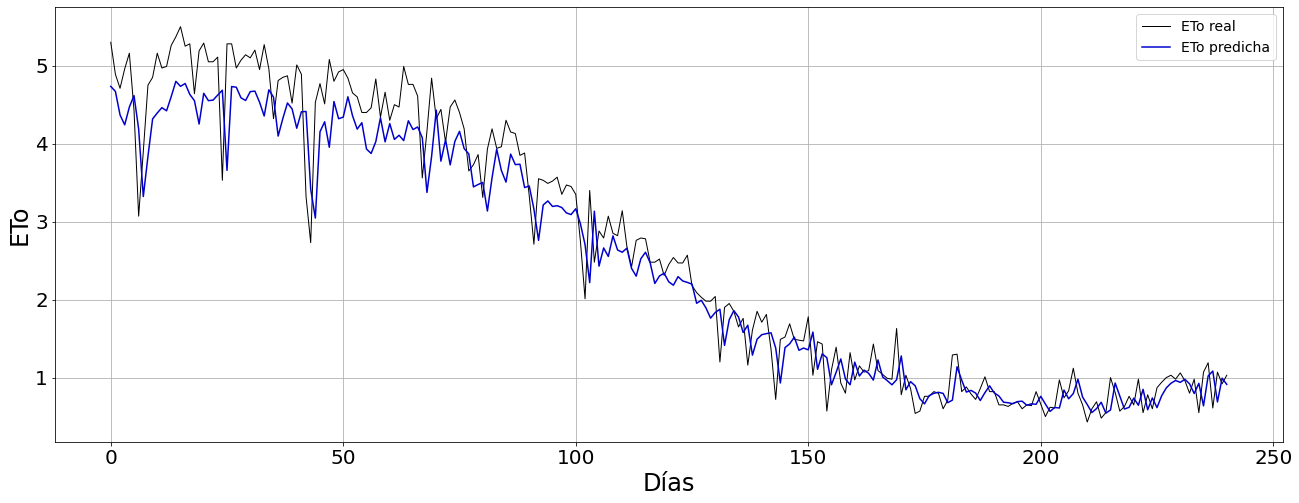

In [ ]:
DIAS_ATRAS = -1000 # Para el gráfico
y_hat_CNN = np.zeros((len(y_test),100))
y_mean = np.zeros((len(y_test)))
y_max = np.zeros((len(y_test)))
y_min = np.zeros((len(y_test)))
x = np.zeros((len(y_test)))
for i in range(len(y_test)):
    y = kde_list[0][i].sample(100)
    y_mean[i] = y.mean()
    y_max[i] = y.max()
    y_min[i] = y.min()
    y_hat_CNN[i,:] = y.reshape(1,-1)
    x[i] = i

fig, ax = plt.subplots(figsize=[22,8])
plt.grid()
plt.plot(x[DIAS_ATRAS:],y_test[DIAS_ATRAS:],'-', color = 'black', ms=4, lw=1, alpha=1, label='ETo real')
plt.plot(x[DIAS_ATRAS:],y_mean[DIAS_ATRAS:],'-', color = 'mediumblue', ms=4, lw=1, alpha=1, label='ETo predicha',linewidth=1.5)
# ax.fill_between(x[DIAS_ATRAS:], y_min[DIAS_ATRAS:], y_max[DIAS_ATRAS:], color='mediumblue', alpha=0.15, label='Intervalo de confianza')
plt.tick_params(labelsize=20)
plt.legend(fontsize=14)
plt.xlabel("Días", fontsize=24)
plt.ylabel("ETo", fontsize=24);

In [ ]:
y_mean

array([4.73423988, 4.66999928, 4.36759513, 4.24142664, 4.46899555,
       4.61663887, 4.18826458, 3.32184684, 3.83703135, 4.31686879,
       4.39294842, 4.46172854, 4.42131017, 4.60258098, 4.79924965,
       4.73497464, 4.77130651, 4.63193186, 4.55079787, 4.25183817,
       4.64560292, 4.55148075, 4.55799539, 4.62297669, 4.68551222,
       3.65737972, 4.73236358, 4.72371341, 4.58838182, 4.5533575 ,
       4.66728087, 4.67368578, 4.53123101, 4.3549027 , 4.69027797,
       4.59670345, 4.0970924 , 4.32107663, 4.52125234, 4.4452538 ,
       4.19766778, 4.40887978, 4.41284066, 3.41690762, 3.04611043,
       4.15307231, 4.28048499, 3.95369315, 4.54060589, 4.31974728,
       4.34021744, 4.60086078, 4.3571007 , 4.18666268, 4.26836821,
       3.93110984, 3.87410351, 4.02580656, 4.33227906, 4.02334007,
       4.25659713, 4.05434909, 4.10751595, 4.03948362, 4.293317  ,
       4.18102892, 4.21412839, 4.07601707, 3.37457361, 3.83656288,
       4.42954568, 3.7753076 , 4.04875351, 3.72791192, 4.02861

In [ ]:
y_test

array([5.3 , 4.89, 4.71, 4.96, 5.16, 4.43, 3.07, 3.9 , 4.75, 4.85, 5.16,
       4.97, 4.99, 5.26, 5.37, 5.5 , 5.25, 5.28, 4.64, 5.19, 5.29, 5.05,
       5.05, 5.11, 3.53, 5.28, 5.28, 4.97, 5.07, 5.14, 5.1 , 5.2 , 4.95,
       5.27, 4.96, 4.32, 4.81, 4.85, 4.87, 4.52, 5.01, 4.89, 3.32, 2.73,
       4.53, 4.77, 4.51, 5.08, 4.8 , 4.92, 4.95, 4.84, 4.65, 4.6 , 4.4 ,
       4.4 , 4.46, 4.83, 4.34, 4.66, 4.3 , 4.5 , 4.47, 4.99, 4.76, 4.76,
       4.61, 3.56, 4.16, 4.84, 4.32, 4.44, 4.02, 4.47, 4.56, 4.4 , 4.19,
       3.65, 3.73, 3.86, 3.31, 3.93, 4.19, 3.94, 3.96, 4.3 , 4.15, 4.13,
       3.85, 3.88, 3.33, 2.71, 3.55, 3.53, 3.49, 3.52, 3.57, 3.35, 3.47,
       3.45, 3.35, 2.75, 2.01, 3.4 , 2.48, 2.88, 2.79, 3.07, 2.85, 2.82,
       3.14, 2.68, 2.42, 2.76, 2.79, 2.78, 2.48, 2.48, 2.52, 2.31, 2.45,
       2.54, 2.47, 2.47, 2.57, 2.18, 2.09, 2.03, 1.98, 1.98, 2.04, 1.2 ,
       1.9 , 1.95, 1.85, 1.65, 1.76, 1.16, 1.61, 1.85, 1.71, 1.81, 1.36,
       0.72, 1.49, 1.52, 1.69, 1.49, 1.48, 1.47, 1.

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
r2 = r2_score(y_test,y_mean)
_rmse = mse(y_test,y_mean,squared=False)

In [ ]:
print('r2: ',r2,' rmse: ',_rmse)

r2:  0.9345158179047628  rmse:  0.43497094601939457


In [ ]:
len(y_mean)

323

##Analysis of residues for the forecast horizon 1

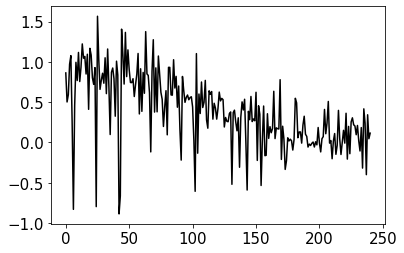

In [ ]:
residuals = y_test - yhat[:,0]
plt.plot(x,residuals,'-', color = 'black', ms=4, lw=1, alpha=1, linewidth=1.5)
plt.tick_params(labelsize=15)

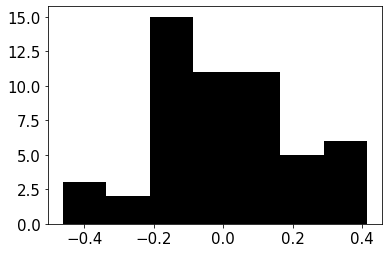

In [ ]:
plt.hist(residuals, bins='auto', color='black')
plt.tick_params(labelsize=15)

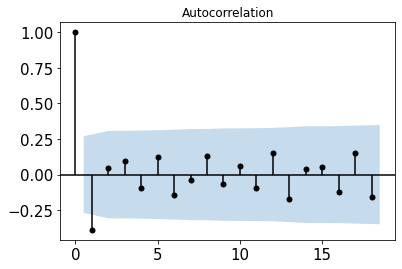

In [ ]:
plot_acf(residuals, plt.gca(), color='black', )
plt.tick_params(labelsize=15)

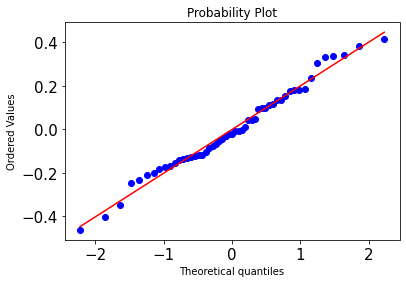

In [ ]:
stats.probplot(np.reshape(residuals, (-1)), dist=stats.norm, plot=plt)
plt.tick_params(labelsize=15)
plt.show()